In [221]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [222]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [223]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Scale the skier numbers

In [234]:
sc_skiers = scale_skiers(df, (0,100), ref_column)
sc_skiers = [round(crowd, 0) for crowd in sc_skiers]
df['skiers'] = sc_skiers

In [242]:
features = list(df.columns.values)
features.remove('skiers')
len(features)

412

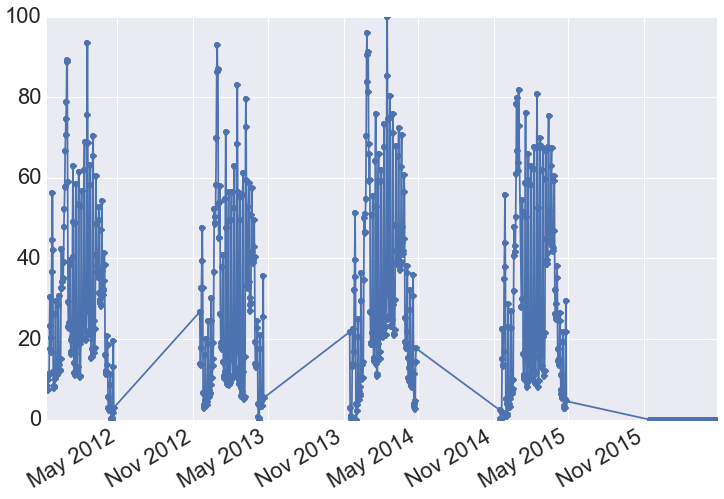

In [243]:
df.skiers.plot(linestyle='-', marker='o')

### Create a training and holdout set

In [244]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
#df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]
df_cv = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]

## Forward selection

In [245]:
lin_regr = linear_model.LinearRegression()

In [246]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [247]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [248]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos].skiers
y_tr_apr = df_tr.iloc[apr_pos].skiers

In [249]:
#leave_out = ['day_5', 'midweek', 'day_0', 'xmas', 'day_4', 'day_0', 'spring_break']
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [14]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  open_lifts_sq , RMSE:  20.5 #: 1
Next best Feature:  month_4 , RMSE:  19.6 #: 2
Next best Feature:  day_5 , RMSE:  18.0 #: 3
Next best Feature:  day_4 , RMSE:  15.6 #: 4
Next best Feature:  days_since_start_xmas_sq , RMSE:  12.8 #: 5
Next best Feature:  days_since_start_spring_break , RMSE:  12.5 #: 6
Next best Feature:  days_since_start_midweek_sq , RMSE:  12.4 #: 7
Next best Feature:  ln_open_percent_midweek , RMSE:  12.1 #: 8
Next best Feature:  month_1_mon , RMSE:  11.8 #: 9
Next best Feature:  thanksgiv_midweek , RMSE:  11.3 #: 10
Next best Feature:  month_2_fri , RMSE:  11.0 #: 11
Next best Feature:  ln_days_since_start , RMSE:  10.8 #: 12
Next best Feature:  month_4_sat , RMSE:  10.7 #: 13
Next best Feature:  ln_open_trails , RMSE:  10.3 #: 14
Next best Feature:  ln_week_snow_tot_fri , RMSE:  10.3 #: 15
Next best Feature:  pres_day_sat , RMSE:  10.0 #: 16
Next best Feature:  ln_week_snow_tot_sat , RMSE:  9.9 #: 17
Next best Feature:  month_4_fri , RMSE:  9.9 

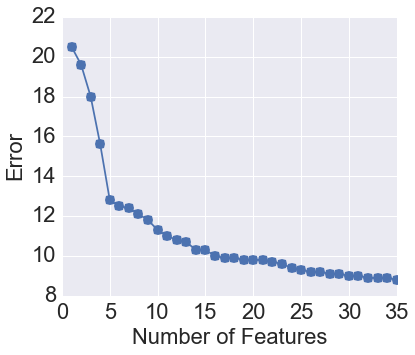

In [155]:
plot_error_vs_features(RMSE, 'none', 'none')

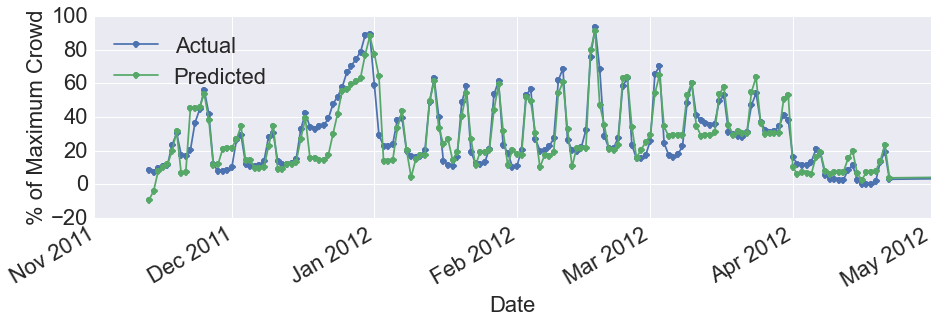

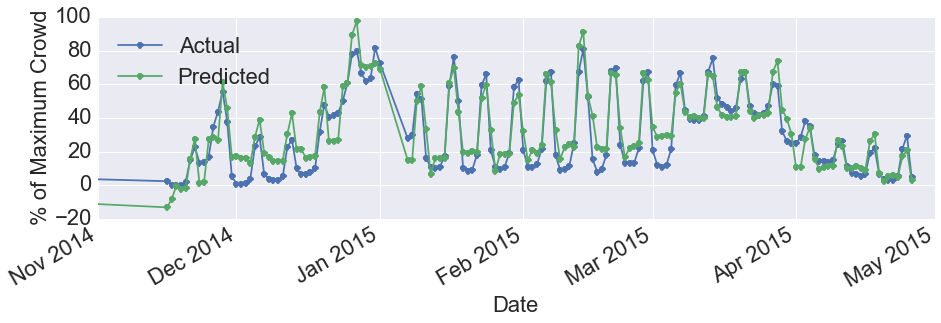

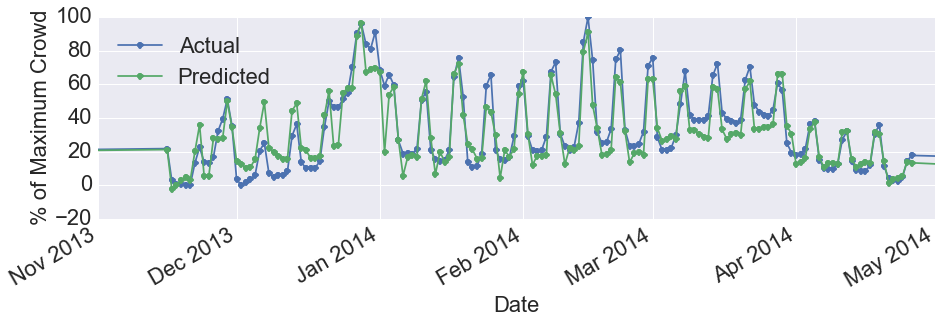

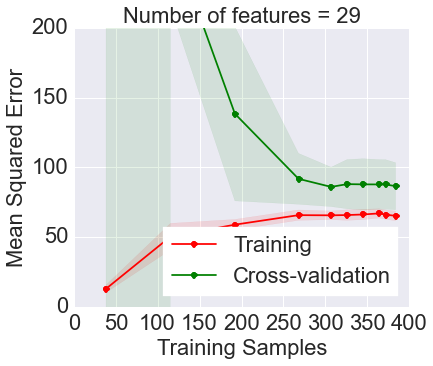

In [156]:
i = 29
while i < 30:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4), '% of Maximum Crowd')
    plot_learning_curve(lin_regr, "Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,200), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

fs_features =  ['open_lifts_sq', 'month_4', 'day_5', 'day_4', 'days_since_start_xmas_sq', 'days_since_start_spring_break', 'days_since_start_midweek_sq', 'ln_open_percent_midweek', 'month_1_mon', 'thanksgiv_midweek', 'month_2_fri', 'ln_days_since_start', 'month_4_sat', 'ln_open_trails', 'ln_week_snow_tot_fri', 'pres_day_sat', 'ln_week_snow_tot_sat', 'month_4_fri', 'month_2_midweek', 'month_1_midweek', 'basedepth_midweek_sqrt', 'thanksgiv_fri', 'open_percent_fri_sq', 'mlk_day', 'month_2_mon', 'pres_day', 'new_24_midweek', 'new_24_sat_sq', 'pres_day_midweek', 'pres_day_mon', 'month_11_mon', 'pres_day_fri', 'week_snow_tot_sat', 'new_24_sat', 'month_2_sat']

In [250]:
num_feat = 29
best_features = fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 9.1 ,  Holdout RMSE: 10.4


In [254]:
X_cv, y_cv, X_cv, y_cv = find_training_and_hold_sets(df_cv, df_cv, best_features, ref_column)
sm_lin = sm.OLS(y_cv, X_cv)
res = sm_lin.fit()
prstd, iv_l, iv_u = wls_prediction_std(res, alpha = 0.32)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     367.4
Date:                Wed, 30 Sep 2015   Prob (F-statistic):               0.00
Time:                        12:57:48   Log-Likelihood:                -2282.1
No. Observations:                 637   AIC:                             4622.
Df Residuals:                     608   BIC:                             4752.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
open_lifts_sq                     0.0355      0.004      9.320      0.000         0.028     0.043
month_4                         -20.1130      1.651    -12.181      0.000       -23.356   -16.870
day_5                            19.1857      2.264      8.475      0.000        14.740    23.632
day_4                            11.2763      2.638      4.274      0.000         6.095    16.458
days_since_start_xmas_sq          0.0224      0.001     26.968      0.000         0.021     0.024
days_since_start_spring_break     0.0794      0.016      4.927      0.000         0.048     0.111
days_since_start_midweek_sq       0.0004      0.000      2.949      0.003         0.000     0.001
ln_open_percent_midweek          -0.9908      0.882     -1.124      0.262        -2.722     0.741
month_1_mon                     -17.7825      2.436     -7.300      0.000       -22.567   -12.998
thanksgiv_midweek                24.1131      2.828      8.526      0.000        18.559    29.667
month_2_fri                       8.4528      2.752      3.071      0.002         3.048    13.858
ln_days_since_start               4.8908      0.665      7.352      0.000         3.584     6.197
month_4_sat                      -6.8627      3.016     -2.275      0.023       -12.786    -0.939
ln_open_trails                   -1.8349      0.729     -2.516      0.012        -3.267    -0.402
ln_week_snow_tot_fri              1.0043      1.013      0.991      0.322        -0.985     2.994
pres_day_sat                     12.1312      5.434      2.232      0.026         1.459    22.803
ln_week_snow_tot_sat              2.9654      0.977      3.036      0.002         1.047     4.883
month_4_fri                      -6.4230      3.112     -2.064      0.039       -12.535    -0.311
month_2_midweek                  -7.2548      1.783     -4.069      0.000       -10.756    -3.753
month_1_midweek                  -4.0352      1.688     -2.391      0.017        -7.349    -0.721
basedepth_midweek_sqrt           -0.0430      0.516     -0.083      0.934        -1.057     0.971
thanksgiv_fri                    27.0782      4.853      5.579      0.000        17.547    36.609
open_percent_fri_sq               0.0016      0.000      5.117      0.000         0.001     0.002
mlk_day                          12.8294      2.374      5.405      0.000         8.168    17.491
month_2_mon                     -14.6263      2.476     -5.906      0.000       -19.490    -9.763
pres_day                         16.0752      2.863      5.615      0.000        10.453    21.697
new_24_midweek                    0.2303      0.240      0.958      0.339        -0.242     0.702
new_24_sat_sq                     0.0345      0.051      0.681      0.496        -0.065     0.134
pres_day_midweek                -13.3387     

In [271]:
coef_conf_int = res.conf_int(alpha=0.32, cols=None)

In [277]:
coef_conf_int[0]

open_lifts_sq                     0.031736
month_4                         -21.756354
day_5                            16.932582
day_4                             8.650298
days_since_start_xmas_sq          0.021609
days_since_start_spring_break     0.063397
days_since_start_midweek_sq       0.000250
ln_open_percent_midweek          -1.868224
month_1_mon                     -20.207001
thanksgiv_midweek                21.298258
month_2_fri                       5.713582
ln_days_since_start               4.228658
month_4_sat                      -9.864455
ln_open_trails                   -2.560898
ln_week_snow_tot_fri             -0.003896
pres_day_sat                      6.722574
ln_week_snow_tot_sat              1.993427
month_4_fri                      -9.520325
month_2_midweek                  -9.029279
month_1_midweek                  -5.714715
basedepth_midweek_sqrt           -0.556811
thanksgiv_fri                    22.247946
open_percent_fri_sq               0.001273
mlk_day    

In [187]:
df_cv_lin['low_pred'] = iv_l
df_cv_lin['upp_pred'] = iv_u

### Cross Validation Fit

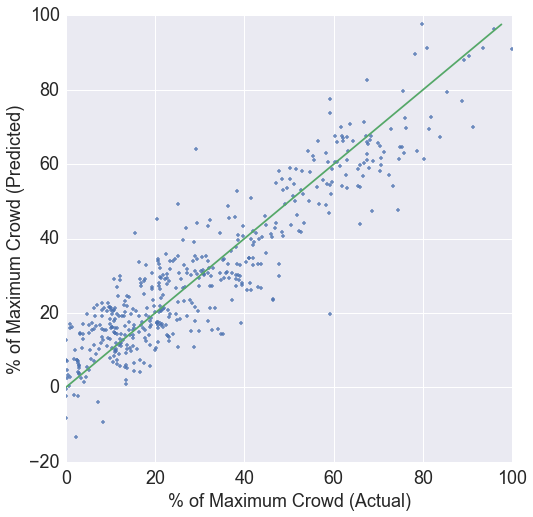

In [33]:
fitted_vs_ref_plot(df_cv_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

### Holdout Fit

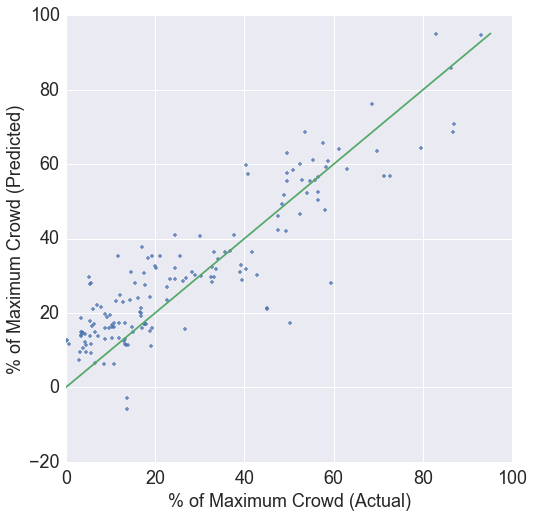

In [35]:
fitted_vs_ref_plot(df_H_lin, ref_column, '% of Maximum Crowd (Predicted)', '% of Maximum Crowd (Actual)')

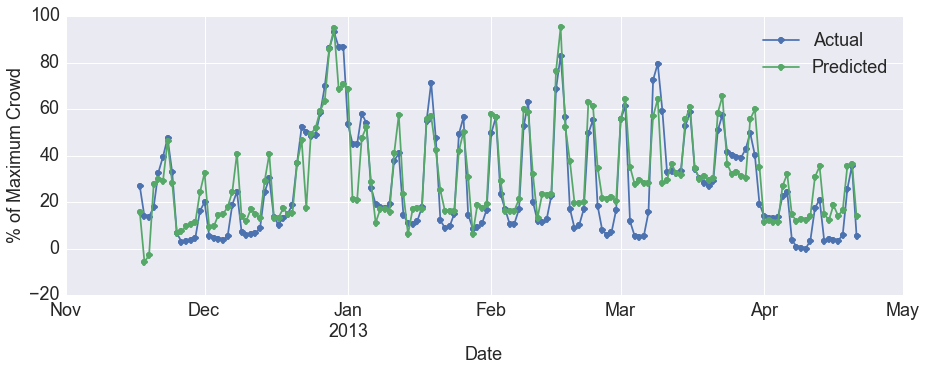

In [138]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE, (15,5), '% of Maximum Crowd')

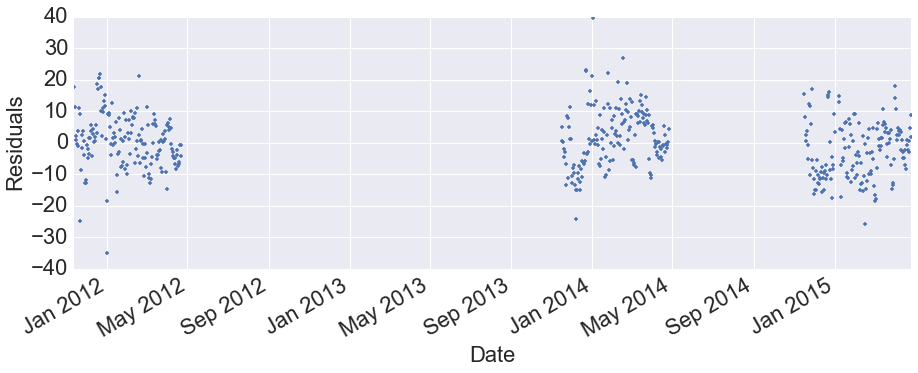

In [169]:
plot_resid_vs_time(df_cv_lin)

In [37]:
df_H_lin['pred_low'] = df_H_lin.pred - RMSE_H_lin
df_H_lin['pred_up'] = df_H_lin.pred + RMSE_H_lin

In [38]:
df_H_lin

,skiers,open_lifts_sq,month_4,day_5,day_4,days_since_start_xmas_sq,days_since_start_spring_break,days_since_start_midweek_sq,ln_open_percent_midweek,month_1_mon,...,open_percent_fri_sq,mlk_day,month_2_mon,pres_day,new_24_midweek,new_24_sat_sq,pres_day_midweek,pred,pred_low,pred_up
2012-11-17,26.763506,9,0,1,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,1,0,15.609731,5.209731,26.009731
2012-11-18,13.769774,9,0,0,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,0,0,-5.787307,-16.187307,4.612693
2012-11-19,13.650383,9,0,0,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,0,0,-2.834601,-13.234601,7.565399
2012-11-20,17.799224,1,0,0,0,0,0,16,0.693147,0,...,0,0,0,0,0.0,0,0,27.532249,17.132249,37.932249
2012-11-21,32.613670,1,0,0,0,0,0,25,0.693147,0,...,0,0,0,0,1.3,0,0,29.679505,19.279505,40.079505
2012-11-22,39.399065,16,0,0,0,0,0,36,1.098612,0,...,0,0,0,0,0.0,0,0,28.846367,18.446367,39.246367
2012-11-23,47.477863,16,0,0,1,0,0,0,0.000000,0,...,9,0,0,0,0.0,0,0,46.108255,35.708255,56.508255
2012-11-24,32.752960,49,0,1,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,0,0,28.269356,17.869356,38.669356
2012-11-25,6.626206,49,0,0,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,0,0,6.558556,-3.841444,16.958556
2012-11-26,2.984778,49,0,0,0,0,0,0,0.000000,0,...,0,0,0,0,0.0,0,0,7.325820,-3.074180,17.725820


### Lasso

In [39]:
features = list(df.columns.values)
features.remove('skiers')

In [40]:
def find_training_and_hold_sets(df_tr, df_h, features):
    X_tr = df_tr[features]
    y_tr = df_tr.skiers.values
    X_h = df_h[features]
    y_h = df_h.skiers.values
    return X_tr, y_tr, X_h, y_h

In [41]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features)

In [42]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 0.0


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


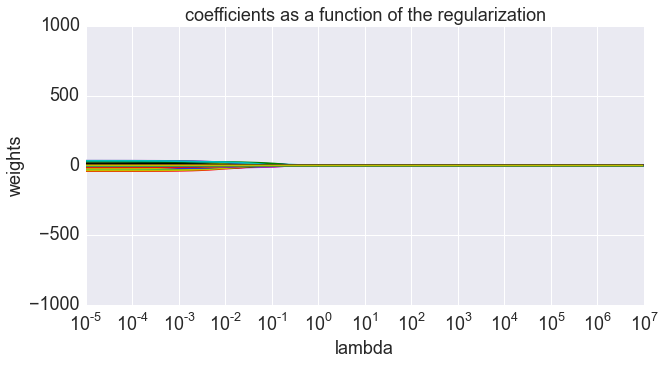

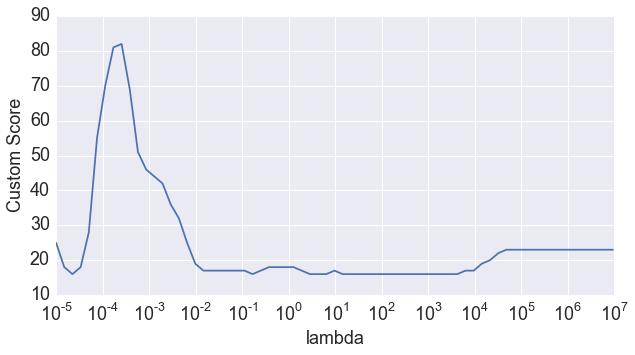

In [43]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [44]:
clf = linear_model.Lasso(alpha=best_lambda)

In [46]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

CV RMSE: 15.5 ,  Holdout RMSE: 12.4


#### Plot the holdout lasso prediction vs the reference data

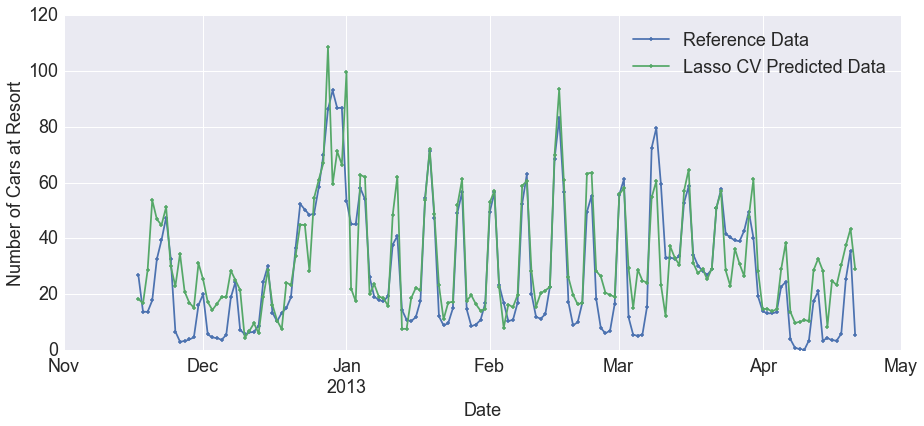

In [47]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [48]:
features = fs_features

In [49]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features]
y_h = df_h.skiers.values

#### Fit the random forest regressor and find cross-validation stats

In [50]:
rfr = RandomForestRegressor(n_estimators = 150, oob_score = True, n_jobs = -1)

In [54]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

CV RMSE: 11.2 ,  Holdout RMSE: 10.7


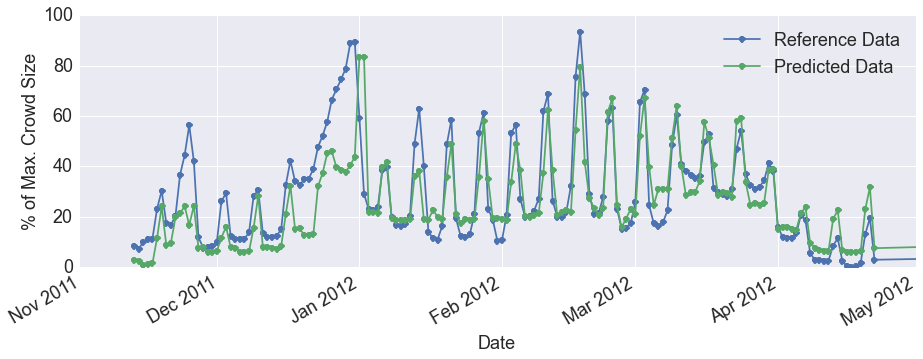

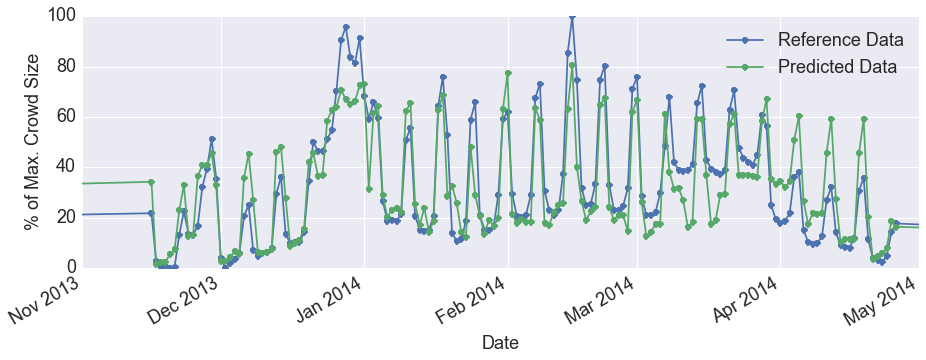

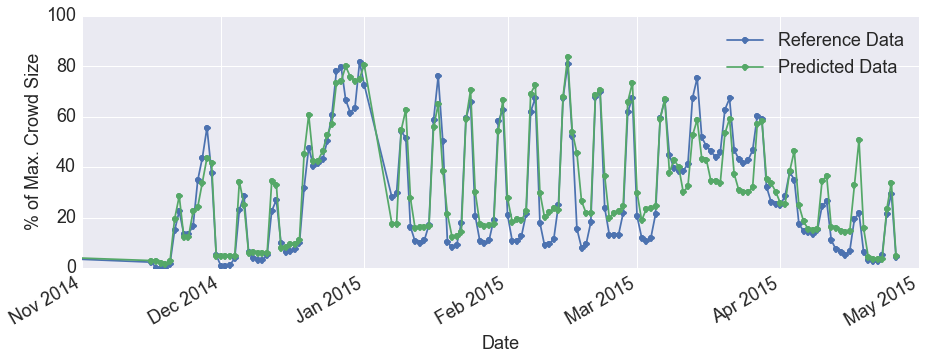

In [55]:
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, 'skiers', ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5))

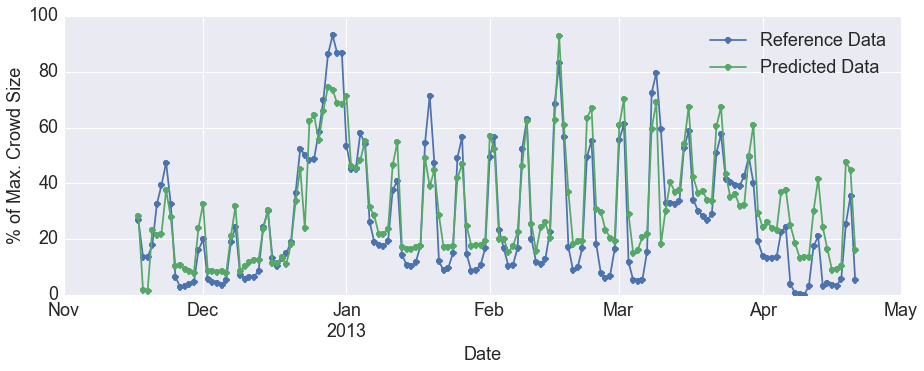

In [56]:
plot_fitted_and_ref_vs_time(df_rf_hold, 'skiers', ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE_rf_H, (15,5))

### Export Linear Model with Best Features to Model

In [57]:
X = df[best_features]
y = df.skiers
mdl = lin_regr.fit(X,y)

In [58]:
#saving pickle file as .p is best
pickle_out = open('../webpage_ski/lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [59]:
df_out = df[best_features]

In [60]:
df_out.to_csv('../webpage_ski/df_all_features.csv')